# 0. Imports

In [2]:
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Union, Tuple, Any
from functools import partial
import chex
import optax
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax, jacfwd, vmap, grad, jit
from jax.tree_util import tree_map, tree_reduce
import flax
import flax.linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.flatten_util import ravel_pytree
from dataclasses import dataclass

from itertools import cycle

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor

import jax_dataloader.core as jdl

from rebayes.base import *
from rebayes.low_rank_filter.lofi import LoFiParams, RebayesLoFi, LoFiBel
from rebayes.extended_kalman_filter.ekf import RebayesEKF
from rebayes.utils.utils import *
from rebayes.utils.avalanche import *
from demos.showdown.nonstationary import hparam_tune_clf as hpt

# 1. Load Dataset

In [3]:
from avalanche.benchmarks.classic import SplitMNIST

n_experiences = 5
dataset = SplitMNIST(n_experiences=n_experiences, seed=1, return_task_id=True,
                         class_ids_from_zero_in_each_exp=True, fixed_class_order=range(10))

ntrain_per_dist, ntrain_per_batch, ntest_per_batch = 1000, 1000, 1000
nval_per_batch = 500

Xtr, Ytr, Xte, Yte =  make_avalanche_data(dataset, ntrain_per_dist, ntrain_per_batch, ntest_per_batch)
ntest_per_batch = ntest_per_batch - nval_per_batch
Xtr, Xte = Xtr.reshape(-1, 1, 28, 28, 1), Xte.reshape(-1, 1, 28, 28, 1)
Xte_batches, Yte_batches = jnp.split(Xte, n_experiences), jnp.split(Yte, n_experiences)
Xval_sets, Yval_sets = [batch[:nval_per_batch] for batch in Xte_batches], [batch[:nval_per_batch] for batch in Yte_batches]
Xte_sets, Yte_sets = [batch[nval_per_batch:] for batch in Xte_batches], [batch[nval_per_batch:] for batch in Yte_batches]

Xval, Yval = jnp.concatenate(Xval_sets), jnp.concatenate(Yval_sets)
Xte, Yte = jnp.concatenate(Xte_sets), jnp.concatenate(Yte_sets)

Xtr_flat = flatten_batch(Xtr)

In [4]:
train, val = (Xtr, Ytr), (Xval, Yval)

In [5]:
train_ds = jdl.Dataset(Xtr, Ytr)
train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)
train_iter = iter(train_loader)

test_ds = jdl.Dataset(Xte, Yte)
test_loader = jdl.DataLoaderJax(test_ds, batch_size=nval_per_batch, shuffle=False, drop_last=False)
test_iter = iter(test_loader)

for b in range(len(train_iter)): 
    (Xb,Yb) = next(train_iter)
    print('batch ', b, Xb.shape, Yb.shape)
    (Xb,Yb) = next(test_iter)
    print('test batch ', b, Xb.shape, Yb.shape)

batch  0 (1000, 1, 28, 28, 1) (1000, 1)
test batch  0 (500, 1, 28, 28, 1) (500, 1)
batch  1 (1000, 1, 28, 28, 1) (1000, 1)
test batch  1 (500, 1, 28, 28, 1) (500, 1)
batch  2 (1000, 1, 28, 28, 1) (1000, 1)
test batch  2 (500, 1, 28, 28, 1) (500, 1)
batch  3 (1000, 1, 28, 28, 1) (1000, 1)
test batch  3 (500, 1, 28, 28, 1) (500, 1)
batch  4 (1000, 1, 28, 28, 1) (1000, 1)
test batch  4 (500, 1, 28, 28, 1) (500, 1)


In [6]:
def plot_batch(Xb, Yb, ttl=None):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(training_data), size=(1,)).item()
        sample_idx = i-1
        img = Xb[sample_idx]
        label = Yb[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    if ttl is not None: plt.suptitle(ttl)
    plt.show()

In [7]:
class RebayesSum(Rebayes):
    """The belief state is the sum of all the input X_t values."""
    def __init__(
        self,
        params: RebayesParams,
        shape_in, 
        shape_out
    ):
        self.params = params
        self.shape_in = shape_in
        self.shape_out = shape_out

    def init_bel(self) -> Belief:
        bel = Belief(dummy = jnp.zeros(self.shape_in))
        return bel
    
    def update_state(
        self,
        bel: Belief,
        X: Float[Array, "input_dim"],
        Y: Float[Array, "obs_dim"]
    ) -> Belief:
        return Belief(dummy = bel.dummy + X)

callback on batch 0
Xtr shape (1000, 1, 28, 28, 1), Ytr shape (1000, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


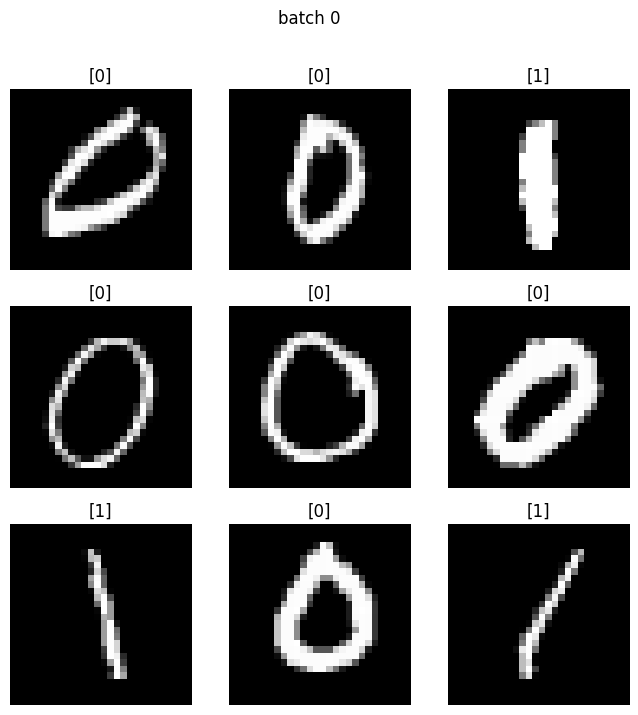

callback on batch 1
Xtr shape (1000, 1, 28, 28, 1), Ytr shape (1000, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


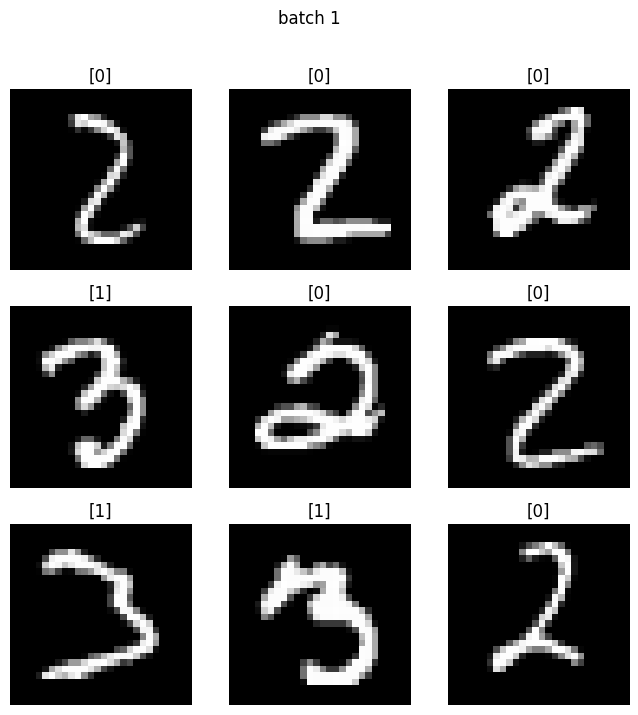

callback on batch 2
Xtr shape (1000, 1, 28, 28, 1), Ytr shape (1000, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


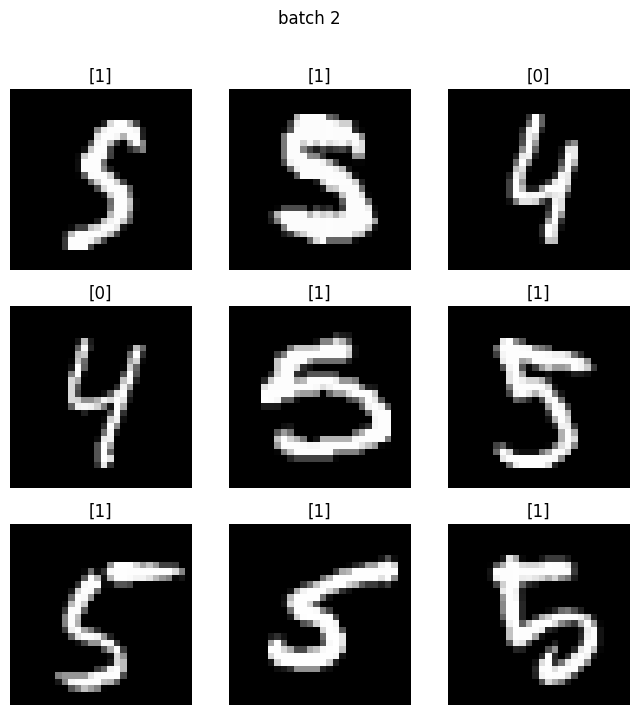

callback on batch 3
Xtr shape (1000, 1, 28, 28, 1), Ytr shape (1000, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


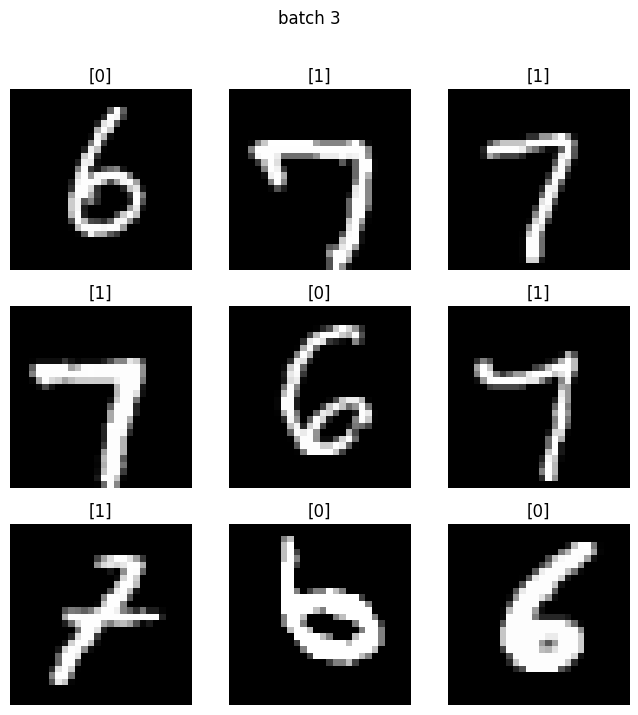

callback on batch 4
Xtr shape (1000, 1, 28, 28, 1), Ytr shape (1000, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


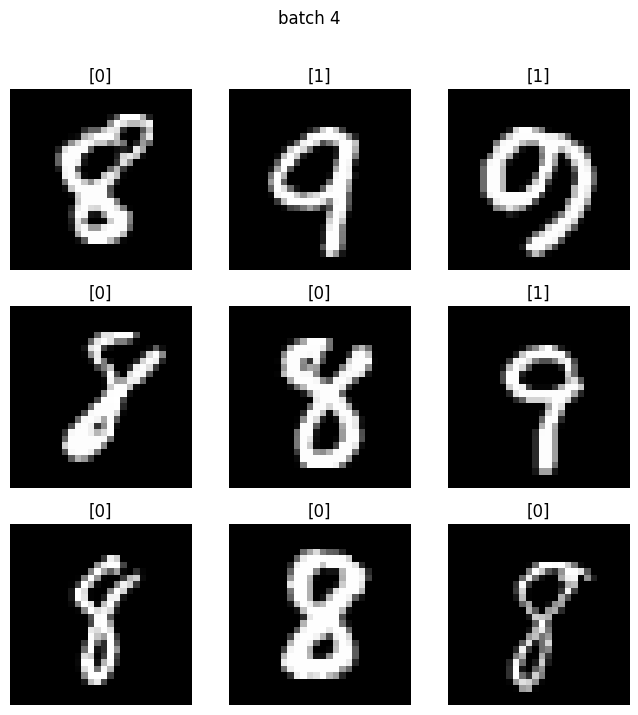

In [9]:
train_ds = jdl.Dataset(Xtr, Ytr)
train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)

test_ds = jdl.Dataset(Xte, Yte)
test_loader = jdl.DataLoaderJax(test_ds, batch_size=nval_per_batch, shuffle=False, drop_last=False)
test_iter = iter(test_loader)

def callback_dl(b, bel_pre, bel_post, batch, **kwargs):
    Xtr, Ytr = batch
    jax.debug.print("callback on batch {b}", b=b)
    jax.debug.print("Xtr shape {x1}, Ytr shape {y1}", x1=Xtr.shape, y1=Ytr.shape)
    Xte, Yte = next(test_iter)
    jax.debug.print("Xte shape {x1}, Yte shape {y1}", x1=Xte.shape, y1=Yte.shape)
    plot_batch(Xte, Yte, ttl='batch {:d}'.format(b))
    return b

shape_in = Xtr.shape[1:]
shape_out = 1
estimator = RebayesSum(make_rebayes_params(), shape_in, shape_out)

bel, outputs = estimator.scan_dataloader(train_loader, callback=callback_dl)
Xsum = jnp.sum(Xtr, axis=0)
# assert(jnp.allclose(Xsum, bel.dummy, atol=1e-1))

# 2. Model Setup

In [10]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

key = jr.PRNGKey(0)
cnn_model = CNN()
cnn_params = cnn_model.init(key, jnp.ones((1, 28, 28, 1)))
flat_params, unflatten_fn = ravel_pytree(cnn_params)
print(f'flat_params.shape: {flat_params.shape}')

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

apply_fn = partial(apply, model=cnn_model, unflatten_fn=unflatten_fn)

flat_params.shape: (420481,)


In [11]:
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), 1e-4, 1-1e-4).ravel()
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

# 3. FDEKF

## 3.1 Hyperparam Tuning

To tune the hyperparameters, we maximize the average validation accuracy across all 5 tasks after training on the full training set.

In [12]:
pbounds={
    'log_init_cov': (-12, 0),
    'log_dynamics_weights': (-12, -3),
    'log_dynamics_cov': (-12, 0),
    'log_alpha': (-12, 0),
}
fcekf_model = 'fcekf'

In [13]:
def evaluate_accuracy(flat_params, apply_fn, X, y):
    """ Evaluate accuracy for given parameters and test set
    """
    @jit
    def evaluate_acc(image, label):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image).ravel()
        acc = jnp.mean(jnp.round(jax.nn.sigmoid(logits)) == label)
        
        return acc
    accs = vmap(evaluate_acc, (0, 0))(X, y).mean()
    return accs

def acc_callback(bel, *args, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test, y_test)
    
    result = {
        'test': accuracy,
    }
    
    return result

def ll_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).squeeze()
    nll = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(logits, y_test))
    if jnp.isnan(nll):
        nll = 1e8
    result = -nll
    
    res = {
        "test": result,
    }
    return res

In [14]:
fdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    cnn_model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    acc_callback, 'fdekf',
)

In [15]:
%%time
fdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | 0.0       | -0.9975   | -4.937    | -9.615    | -2.602    |
| 2         | 0.0       | -0.984    | -2.072    | -5.448    | -8.874    |
| 3         | 0.0       | -1.059    | -8.871    | -5.103    | -8.862    |
| 4         | 0.51      | -10.53    | -7.368    | -4.439    | -8.662    |


## 3.2 Test Set Accuracy

In [ ]:
fdekf_hparams = hpt.get_best_params(fdekf_optimizer)
fdekf_estimator = hpt.build_estimator(flat_params, fdekf_hparams, emission_mean_function,
                                      emission_cov_function, method="fdekf")

In [ ]:
def test_acc_callback(i, bel_pre, bel_post, batch, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    ntest_per_batch = kwargs["ntest_per_batch"]
    X_test, y_test = X_test[:(i+1)*ntest_per_batch], y_test[:(i+1)*ntest_per_batch]
    apply_fn = kwargs["apply_fn"]
    
    overall_accuracy = evaluate_accuracy(bel_post.mean, apply_fn, X_test, y_test)
    task1_accuracy = evaluate_accuracy(bel_post.mean, apply_fn, X_test[:ntest_per_batch], y_test[:ntest_per_batch])
    result = {
        'overall': overall_accuracy,
        'task1': task1_accuracy,
    }
    return result

In [ ]:
test_kwargs = {
    'X_test': Xte,
    'y_test': Yte,
    'ntest_per_batch': ntest_per_batch,
    'apply_fn': apply_fn,
}
_, fdekf_accs = fdekf_estimator.scan_dataloader(train_loader, callback=test_acc_callback, **test_kwargs)

In [ ]:
fdekf_accs

[{'overall': Array(0.998, dtype=float32),
  'task1': Array(0.998, dtype=float32)},
 {'overall': Array(0.892, dtype=float32),
  'task1': Array(0.836, dtype=float32)},
 {'overall': Array(0.6853333, dtype=float32),
  'task1': Array(0.388, dtype=float32)},
 {'overall': Array(0.7695, dtype=float32),
  'task1': Array(0.71400005, dtype=float32)},
 {'overall': Array(0.4888, dtype=float32),
  'task1': Array(0.46800002, dtype=float32)}]

# 4. VDEKF

## 4.1 Hyperparam Tuning

In [ ]:
vdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    cnn_model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    acc_callback, 'vdekf',
)

In [ ]:
%%time
vdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

## 4.2 Test Set Accuracy

In [ ]:
vdekf_hparams = hpt.get_best_params(vdekf_optimizer)
vdekf_estimator = hpt.build_estimator(flat_params, vdekf_hparams, emission_mean_function,
                                      emission_cov_function, method="vdekf")

In [ ]:
_, vdekf_accs = vdekf_estimator.scan_dataloader(train_loader, callback=test_acc_callback, **test_kwargs)

In [ ]:
vdekf_accs

# 5. LoFi-Orth

## 5.1 Hyperparam Tuning

In [ ]:
lofi_params_spherical = LoFiParams(
    memory_size=20,
    diagonal_covariance=False,
)

In [ ]:
lofi_orth_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    cnn_model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    acc_callback, 'lofi_orth', params_lofi=lofi_params_spherical
)

In [ ]:
%%time
lofi_orth_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | 0.5448    | -0.9975   | -4.937    | -9.615    | -2.602    |
| 2         | 0.49      | -0.984    | -2.072    | -5.448    | -8.874    |
| 3         | 0.49      | -1.059    | -8.871    | -5.103    | -8.862    |
| 4         | 0.49      | -10.53    | -7.368    | -4.439    | -8.662    |
| 5         | 0.51      | -11.16    | -4.403    | -6.737    | -5.025    |
| 6         | 0.49      | -3.874    | -3.754    | -8.05     | -8.149    |
| 7         | 0.4904    | -5.153    | -6.242    | -4.25     | -1.982    |
| 8         | 0.5856    | -10.73    | -11.28    | -6.628    | -2.491    |
| 9         | 0.49      | -9.284    | -5.578    | -10.78    | -7.533    |
| 10        | 0.5488    | -10.18    | -6.842    | -4.866    | -7.117    |
| 11        | 0.49      | -9.866    | -1.089    | -7.092    | -10.79    |
| 12        | 0.51      | -3.375    | 

## 5.2 Test Set Accuracy

In [ ]:
lofi_orth_hparams = hpt.get_best_params(lofi_orth_optimizer)
lofi_orth_estimator = hpt.build_estimator(flat_params, lofi_orth_hparams, emission_mean_function,
                                          emission_cov_function, method="lofi_orth", 
                                          lofi_params=lofi_params_spherical)

In [ ]:
_, lofi_orth_accs = lofi_orth_estimator.scan_dataloader(train_loader, callback=test_acc_callback, **test_kwargs)

In [ ]:
lofi_orth_accs

# 6. LoFi-Spherical

## 6.1 Hyperparam Tuning

In [ ]:
lofi_sph_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    cnn_model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    acc_callback, 'lofi', params_lofi=lofi_params_spherical
)

In [ ]:
%%time
lofi_sph_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

## 6.2 Test Set Accuracy

In [ ]:
lofi_sph_hparams = hpt.get_best_params(lofi_sph_optimizer)
lofi_sph_estimator = hpt.build_estimator(flat_params, lofi_sph_hparams, emission_mean_function,
                                         emission_cov_function, method="lofi", 
                                         lofi_params=lofi_params_spherical)

In [ ]:
_, lofi_sph_accs = lofi_sph_estimator.scan_dataloader(train_loader, callback=test_acc_callback, **test_kwargs)

In [ ]:
lofi_sph_accs

# 7. LoFi-Diag

## 7.1 Hyperparam Tuning

In [ ]:
lofi_params_diagonal = LoFiParams(
    memory_size=20,
    diagonal_covariance=True,
)

In [ ]:
lofi_diag_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    cnn_model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    acc_callback, 'lofi', params_lofi=lofi_params_diagonal
)

In [ ]:
%%time
lofi_diag_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

## 7.2 Test Set Accuracy

In [ ]:
lofi_diag_hparams = hpt.get_best_params(lofi_diag_optimizer)
lofi_diag_estimator = hpt.build_estimator(flat_params, lofi_diag_hparams, emission_mean_function,
                                          emission_cov_function, method="lofi", 
                                          lofi_params=lofi_params_diagonal)

In [ ]:
_, lofi_diag_accs = lofi_diag_estimator.scan_dataloader(train_loader, callback=test_acc_callback, **test_kwargs)

In [ ]:
lofi_diag_accs

# 8. Model Comparison